In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

In [2]:
def rgb2gray(_img):
    img = _img.copy().astype(np.float)
    r = img[..., 2].copy()
    g = img[..., 1].copy()
    b = img[..., 0].copy()
    img = 0.2126 * r + 0.7152 * g + 0.0722 * b
    img = img.astype(np.uint8)
    return img

In [3]:
def rgb2hsv(_img):
    img = _img.copy() / 255
    hsv = np.zeros_like(img)
    
    _max = np.max(img, axis=2)
    _min = np.min(img, axis=2)
    min_idx = np.argmin(img, axis=2)
    
    #H
    hsv[..., 0][np.where(_max == _min)] = 0
    a = np.where(min_idx == 2)
    hsv[..., 0][a] = (60 * (img[..., 1][a] - img[..., 0][a])) / (_max[a] - _min[a]) + 60
    a = np.where(min_idx == 0)
    hsv[..., 0][a] = (60 * (img[..., 2][a] - img[..., 1][a])) / (_max[a] - _min[a]) + 180
    a = np.where(min_idx == 1)
    hsv[..., 0][a] = (60 * (img[..., 0][a] - img[..., 2][a])) / (_max[a] - _min[a]) + 300
    
    #S
    hsv[..., 1] = _max - _min
    
    #V
    hsv[..., 2] = _max
    
    return hsv

In [4]:
def bl_interpolate(img, ax=1., ay=1.):
	if len(img.shape) > 2:
		H, W, C = img.shape
	else:
		H, W = img.shape
		C = 1

	aH = int(ay * H)
	aW = int(ax * W)

	# get position of resized image
	y = np.arange(aH).repeat(aW).reshape(aW, -1)
	x = np.tile(np.arange(aW), (aH, 1))

	# get position of original position
	y = (y / ay)
	x = (x / ax)

	ix = np.floor(x).astype(np.int)
	iy = np.floor(y).astype(np.int)

	ix = np.minimum(ix, W-2)
	iy = np.minimum(iy, H-2)

	# get distance 
	dx = x - ix
	dy = y - iy

	if C > 1:
		dx = np.repeat(np.expand_dims(dx, axis=-1), C, axis=-1)
		dy = np.repeat(np.expand_dims(dy, axis=-1), C, axis=-1)

	# interpolation
	out = (1-dx) * (1-dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix+1] + (1 - dx) * dy * img[iy+1, ix] + dx * dy * img[iy+1, ix+1]

	out = np.clip(out, 0, 255)
	out = out.astype(np.uint8)

	return out

In [5]:
def sobel(_img, size=3):
    img = _img.astype(np.float32)
    out_x = np.zeros_like(img.copy())
    out_y = np.zeros_like(img.copy())
    pad = size // 2
    
    kx = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]
    ky = [[1, 0, -1], [2, 0, -2], [1, 0, -1]]
    
    h, w = img.shape
    for i in range(pad, h-pad):
        for j in range(pad, w-pad):
            out_x[i, j] = np.mean(img[i-pad:i+pad+1, j-pad:j+pad+1] * kx)
            out_y[i, j] = np.mean(img[i-pad:i+pad+1, j-pad:j+pad+1] * ky)
    
    out_x = np.clip(out_x, 0, 255)
    out_y = np.clip(out_y, 0, 255)

    return out_x, out_y

In [6]:
def gaussian_filter(_img, size=3, sigma=1.3):
    img = _img.copy().astype(np.float)
    out = np.zeros_like(img)
    pad = size // 2
    
    ker = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            x = i - pad
            y = j - pad
            ker[i, j] = 1 / (2 * np.pi * sigma**2) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    ker = ker / np.sum(ker)
    
    h, w = img.shape
    for i in range(pad, h-pad):
        for j in range(pad, w-pad):
            out[i, j] = np.sum(img[i-pad:i+pad+1, j-pad:j+pad+1] * ker)
    return out.astype(np.uint8)

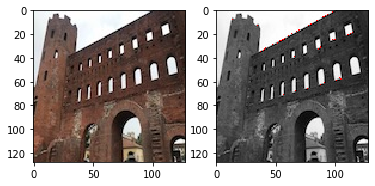

In [23]:
#81
def hessian(_img):
    gray = rgb2gray(_img)
    h, w = gray.shape
    
    ix, iy = sobel(gray)
    ixx, ixy, iyy = ix**2, ix*iy, iy**2
    
    deth = ixx * iyy - ixy**2
    
    out = np.zeros((h, w, 3))
    
    for i in range(h):
        for j in range(w):
            for c in range(3):
                out[i, j, c] = gray[i, j]
    
    m = np.max(deth)
    for i in range(1, h-1):
        for j in range(1, w-1):
            if (np.max(deth[i-1:i+2, j-1:j+2]) == deth[i, j] and deth[i, j] > m*0.1):
                out[i, j] = [255, 0, 0]
    
    
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    return out


img = cv2.imread('thorino.jpg')
img = img[..., ::-1]

out = hessian(img)


plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')
plt.show()

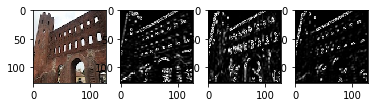

In [27]:
#82
def harris1(_img, k=0.04, th=0.4):
    gray = rgb2gray(_img)
    h, w = gray.shape
    
    ix, iy = sobel(gray)
    ixx, ixy, iyy = ix**2, ix*iy, iy**2
    
    deth = ixx * iyy - ixy**2
    
    ixx = gaussian_filter(ixx, sigma=3)
    iyy = gaussian_filter(iyy, sigma=3)
    ixy = gaussian_filter(ixy, sigma=3)
    
    ixx = ixx.astype(np.uint8)
    iyy = iyy.astype(np.uint8)
    ixy = ixy.astype(np.uint8)
    
    return ixx, iyy, ixy
    
img = cv2.imread('thorino.jpg')
img = img[..., ::-1]

ixx, iyy, ixy = harris1(img)

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.subplot(1, 4, 2)
plt.imshow(ixx, cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(iyy, cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(ixy, cmap='gray')
plt.show()

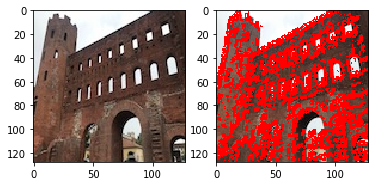

In [30]:
#83
def harris2(_img, ixx, iyy, ixy, k=0.04, th=0.1):
    out = _img.copy().astype(np.uint8)
    
    deth = ixx * iyy - ixy**2
    traceh = ixx + iyy
    r = deth - k * traceh**2
    
    idx = np.where(r >= np.max(r)*th)
    out[idx] = [255, 0, 0]
    
    return out
    
    
img = cv2.imread('thorino.jpg')
img = img[..., ::-1]

ixx, iyy, ixy = harris1(img)
out = harris2(img, ixx, iyy, ixy)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')
plt.show()

[[  172 12254  2983   975   485 11576  3395   928   387 10090  4845  1062
      0]
 [ 3627  7350  4420   987  1743  8438  4651  1552   848  9089  4979  1468
      0]
 [ 1646  6547  5807  2384  1715  8502  5233   934  1553  5270  7167  2394
      0]
 [  749 10142  5465    28  1431  7922  7001    30  1492  7819  7024    49
      0]
 [  927  4197  8581  2679   669  5689  7959  2067   506  3973  6387  5518
      0]
 [ 2821  6404  2540  4619  1625  7317  3019  4423   225  8635  1591  5933
      1]
 [ 5575  7831  1619  1359  4638  6777  3553  1416  4675  7964  2176  1569
      1]
 [ 4867  7523  3275   719  4457  6390  3049  2488  4328  7135  3377  1544
      1]
 [ 7881  6160  1992   351  7426  3967  4258   733  7359  4979  3322   724
      1]
 [ 5638  6580  3916   250  5041  4185  6286   872  5226  4930  5552   676
      1]]


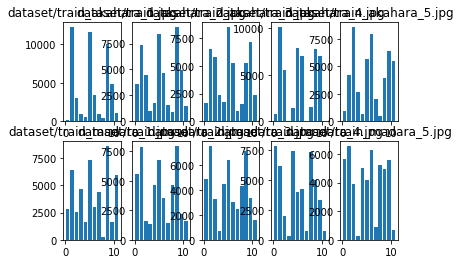

In [32]:
#84
def dic_color(img):
    img //= 63
    img = img * 64 + 32
    return img


def training():
    train = glob('dataset/train_*')
    train.sort()

    db = np.zeros((len(train), 13), dtype=np.int32)

    for i, path in enumerate(train):
        img = cv2.imread(path)
        img = dic_color(img)
    
        for j in range(4):
            db[i, j] = len(np.where(img[..., 0] == 64 * j + 32)[0])
            db[i, j+4] = len(np.where(img[..., 1] == 64 * j + 32)[0])
            db[i, j+8] = len(np.where(img[..., 2] == 64 * j + 32)[0])
        
        if 'akahara' in path:
            db[i, -1] = 0
        else:
            db[i, -1] = 1
        
        h = img.copy()
        h //= 64
        h[..., 1] += 4
        h[..., 2] += 8
    
        plt.subplot(2, 5, i+1)
        plt.hist(h.ravel(), bins=12, rwidth=0.8)
        plt.title(path)
        
    print(db)
    plt.show()
    

training()

In [63]:
def get_db():
    train = glob('dataset/train_*')
    train.sort()

    db = np.zeros((len(train), 13), dtype=np.int32)
    pdb = []

    for i, path in enumerate(train):
        img = cv2.imread(path)
        img = dic_color(img)
    
        for j in range(4):
            db[i, j] = len(np.where(img[..., 0] == 64 * j + 32)[0])
            db[i, j+4] = len(np.where(img[..., 1] == 64 * j + 32)[0])
            db[i, j+8] = len(np.where(img[..., 2] == 64 * j + 32)[0])
        
        if 'akahara' in path:
            db[i, -1] = 0
        else:
            db[i, -1] = 1
            
        pdb.append(path)
        
    return db, pdb

[[  172 12254  2983   975   485 11576  3395   928   387 10090  4845  1062
      0]
 [ 3627  7350  4420   987  1743  8438  4651  1552   848  9089  4979  1468
      0]
 [ 1646  6547  5807  2384  1715  8502  5233   934  1553  5270  7167  2394
      0]
 [  749 10142  5465    28  1431  7922  7001    30  1492  7819  7024    49
      0]
 [  927  4197  8581  2679   669  5689  7959  2067   506  3973  6387  5518
      0]
 [ 2821  6404  2540  4619  1625  7317  3019  4423   225  8635  1591  5933
      1]
 [ 5575  7831  1619  1359  4638  6777  3553  1416  4675  7964  2176  1569
      1]
 [ 4867  7523  3275   719  4457  6390  3049  2488  4328  7135  3377  1544
      1]
 [ 7881  6160  1992   351  7426  3967  4258   733  7359  4979  3322   724
      1]
 [ 5638  6580  3916   250  5041  4185  6286   872  5226  4930  5552   676
      1]]


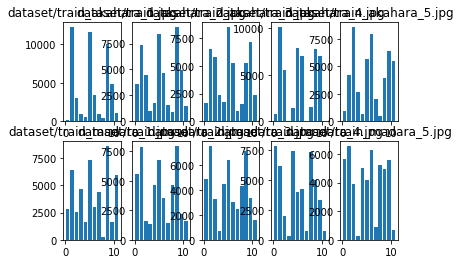

dataset/test_akahara_1.jpg is similar >> dataset/train_akahara_3.jpg  Pred >> akahara
dataset/test_akahara_2.jpg is similar >> dataset/train_akahara_1.jpg  Pred >> akahara
dataset/test_madara_1.jpg is similar >> dataset/train_madara_2.jpg  Pred >> madara
dataset/test_madara_2.jpg is similar >> dataset/train_akahara_2.jpg  Pred >> akahara


In [43]:
#85
training()
test = glob('dataset/test_*')
test.sort()

for i, path in enumerate(test):
    img = cv2.imread(path)
    img = dic_color(img)
    h = np.zeros(12, dtype=np.int32)
    
    for j in range(4):
        h[j] = len(np.where(img[..., 0] == 64 * j + 32)[0])
        h[j+4] = len(np.where(img[..., 1] == 64 * j + 32)[0])
        h[j+8] = len(np.where(img[..., 2] == 64 * j + 32)[0])

    dif = 999999
    cls = 0
    p = 0
    for num, x in enumerate(db):
        sum = 0
        for y in range(len(x)-1):
            sum += np.abs(h[y] - x[y])
        if sum < dif:
            dif = sum
            cls = x[-1]
            p = num
            
    if cls == 0:
        cname = 'akahara'
    else:
        cname = 'madara'
        
    print(path + ' is similar >> ' + train[p] + '  Pred >> ' + cname)

[[  172 12254  2983   975   485 11576  3395   928   387 10090  4845  1062
      0]
 [ 3627  7350  4420   987  1743  8438  4651  1552   848  9089  4979  1468
      0]
 [ 1646  6547  5807  2384  1715  8502  5233   934  1553  5270  7167  2394
      0]
 [  749 10142  5465    28  1431  7922  7001    30  1492  7819  7024    49
      0]
 [  927  4197  8581  2679   669  5689  7959  2067   506  3973  6387  5518
      0]
 [ 2821  6404  2540  4619  1625  7317  3019  4423   225  8635  1591  5933
      1]
 [ 5575  7831  1619  1359  4638  6777  3553  1416  4675  7964  2176  1569
      1]
 [ 4867  7523  3275   719  4457  6390  3049  2488  4328  7135  3377  1544
      1]
 [ 7881  6160  1992   351  7426  3967  4258   733  7359  4979  3322   724
      1]
 [ 5638  6580  3916   250  5041  4185  6286   872  5226  4930  5552   676
      1]]


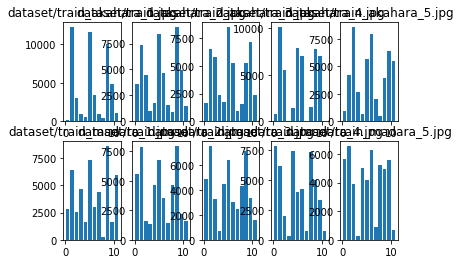

dataset/test_akahara_1.jpg is similar >> dataset/train_akahara_3.jpg  Pred >> akahara
dataset/test_akahara_2.jpg is similar >> dataset/train_akahara_1.jpg  Pred >> akahara
dataset/test_madara_1.jpg is similar >> dataset/train_madara_2.jpg  Pred >> madara
dataset/test_madara_2.jpg is similar >> dataset/train_akahara_2.jpg  Pred >> akahara
Accuracy >> 0.75


In [47]:
#86
training()
test = glob('dataset/test_*')
test.sort()

acc = 0
for i, path in enumerate(test):
    img = cv2.imread(path)
    img = dic_color(img)
    h = np.zeros(12, dtype=np.int32)
    
    for j in range(4):
        h[j] = len(np.where(img[..., 0] == 64 * j + 32)[0])
        h[j+4] = len(np.where(img[..., 1] == 64 * j + 32)[0])
        h[j+8] = len(np.where(img[..., 2] == 64 * j + 32)[0])

    dif = 999999
    cls = 0
    p = 0
    for num, x in enumerate(db):
        sum = 0
        for y in range(len(x)-1):
            sum += np.abs(h[y] - x[y])
        if sum < dif:
            dif = sum
            cls = x[-1]
            p = num
            
    if cls == 0:
        cname = 'akahara'
    else:
        cname = 'madara'
        
    print(path + ' is similar >> ' + train[p] + '  Pred >> ' + cname)
    
    if 'akahara' in path:
        acls = 0
    else:
        acls = 1
            
    if cls == acls:
        acc += 1
        
print('Accuracy >> ' + str(acc/len(test)))

[[  172 12254  2983   975   485 11576  3395   928   387 10090  4845  1062
      0]
 [ 3627  7350  4420   987  1743  8438  4651  1552   848  9089  4979  1468
      0]
 [ 1646  6547  5807  2384  1715  8502  5233   934  1553  5270  7167  2394
      0]
 [  749 10142  5465    28  1431  7922  7001    30  1492  7819  7024    49
      0]
 [  927  4197  8581  2679   669  5689  7959  2067   506  3973  6387  5518
      0]
 [ 2821  6404  2540  4619  1625  7317  3019  4423   225  8635  1591  5933
      1]
 [ 5575  7831  1619  1359  4638  6777  3553  1416  4675  7964  2176  1569
      1]
 [ 4867  7523  3275   719  4457  6390  3049  2488  4328  7135  3377  1544
      1]
 [ 7881  6160  1992   351  7426  3967  4258   733  7359  4979  3322   724
      1]
 [ 5638  6580  3916   250  5041  4185  6286   872  5226  4930  5552   676
      1]]


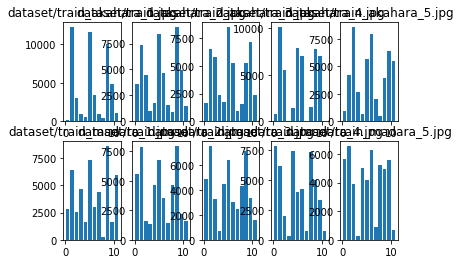

dataset/test_akahara_1.jpg is similar >> dataset/train_akahara_3.jpg, dataset/train_akahara_2.jpg, dataset/train_akahara_4.jpg,   Pred >> akahara
dataset/test_akahara_2.jpg is similar >> dataset/train_akahara_1.jpg, dataset/train_akahara_2.jpg, dataset/train_akahara_4.jpg,   Pred >> akahara
dataset/test_madara_1.jpg is similar >> dataset/train_madara_2.jpg, dataset/train_madara_4.jpg, dataset/train_madara_3.jpg,   Pred >> madara
dataset/test_madara_2.jpg is similar >> dataset/train_akahara_2.jpg, dataset/train_madara_3.jpg, dataset/train_madara_2.jpg,   Pred >> madara
Accuracy >> 1.0


In [62]:
#87
training()
test = glob('dataset/test_*')
test.sort()

acc = 0
for i, path in enumerate(test):
    img = cv2.imread(path)
    img = dic_color(img)
    h = np.zeros(12, dtype=np.int32)
    
    for j in range(4):
        h[j] = len(np.where(img[..., 0] == 64 * j + 32)[0])
        h[j+4] = len(np.where(img[..., 1] == 64 * j + 32)[0])
        h[j+8] = len(np.where(img[..., 2] == 64 * j + 32)[0])

    dif = 999999
    sum = np.zeros(len(train), dtype=np.int32)
    for num, x in enumerate(db):
        for y in range(len(x)-1):
            sum[num] += np.abs(h[y] - x[y])
    
    idx = np.argsort(sum)
    clss = 0
    for n in idx[:3]:
        clss += db[n][-1]
    
    if clss < 2:
        clss = 0
    else:
        clss = 1
            
    if clss == 0:
        cname = 'akahara'
    else:
        cname = 'madara'
        
    print(path + ' is similar >> ' + train[idx[0]] + ', ' + train[idx[1]] + ', ' + train[idx[2]] + ', ' + '  Pred >> ' + cname)
    
    if 'akahara' in path:
        acls = 0
    else:
        acls = 1
            
    if clss == acls:
        acc += 1
        
print('Accuracy >> ' + str(acc/len(test)))

In [79]:
#88
def get_db():
    train = glob('dataset/test_*')
    train.sort()

    db = np.zeros((len(train), 13), dtype=np.int32)
    pdb = []

    for i, path in enumerate(train):
        img = cv2.imread(path)
        img = dic_color(img)
    
        for j in range(4):
            db[i, j] = len(np.where(img[..., 0] == 64 * j + 32)[0])
            db[i, j+4] = len(np.where(img[..., 1] == 64 * j + 32)[0])
            db[i, j+8] = len(np.where(img[..., 2] == 64 * j + 32)[0])
        
        if 'akahara' in path:
            db[i, -1] = 0
        else:
            db[i, -1] = 1
            
        pdb.append(path)
        
    return db, pdb


def kmeans(db, pdb, clss=2):
    feats = db.copy()
    np.random.seed(1)
    
    for i in range(len(feats)):
        if np.random.random() < 0.5:
            feats[i, -1] = 0
        else:
            feats[i, -1] = 1
            
    gs = np.zeros((clss, 12), dtype=np.float32)
    for i in range(clss):
        gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)
        
    print('assigned label')
    print(feats)
    print('Grabity')
    print(gs)
    
    
db, pdb = get_db()
kmeans(db, pdb)

assigned label
[[ 1493  7892  4900  2099  1828  9127  4534   895  1554  6750  5406  2674
      0]
 [  242 10338  3628  2176   587 12212  2247  1338   434 10822  4506   622
      1]
 [ 6421  5478   719  3766  5482  4294  2537  4071  5609  4823  2051  3901
      0]
 [ 3343  8134  4756   151  3787  7588  3935  1074  3595  8444  4069   276
      0]]
Grabity
[[ 3752.3333  7168.      3458.3333  2005.3334  3699.      7003.
   3668.6667  2013.3334  3586.      6672.3335  3842.      2283.6667]
 [  242.     10338.      3628.      2176.       587.     12212.
   2247.      1338.       434.     10822.      4506.       622.    ]]


In [92]:
#89
def get_db():
    train = glob('dataset/test_*')
    train.sort()

    db = np.zeros((len(train), 13), dtype=np.int32)
    pdb = []

    for i, path in enumerate(train):
        img = cv2.imread(path)
        img = dic_color(img)
    
        for j in range(4):
            db[i, j] = len(np.where(img[..., 0] == 64 * j + 32)[0])
            db[i, j+4] = len(np.where(img[..., 1] == 64 * j + 32)[0])
            db[i, j+8] = len(np.where(img[..., 2] == 64 * j + 32)[0])
        
        if 'akahara' in path:
            db[i, -1] = 0
        else:
            db[i, -1] = 1
            
        pdb.append(path)
        
    return db, pdb


def kmeans(db, pdb, clss=2, th=0.5):
    feats = db.copy()
    np.random.seed(1)
    
    flg = 1
    for i in range(len(feats)):
        if np.random.random() < th:
            feats[i, -1] = 0
        else:
            feats[i, -1] = 1
            
    flg = 0
    while flg == 1:
        gs = np.zeros((clss, 12), dtype=np.float32)
        for i in range(clss):
            gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)
    
        for feat in feats:
            m = 999999
            c = 0
            for i in range(clss):
                d = np.sqrt(np.sum((feat[:12] - gs[i])**2))
                if d < m:
                    m = d
                    c = i
            if feat[-1] != c:
                feat[-1] = c
                flg = 0
    
    for i in range(len(feats)):
        print(pdb[i] + '  Pred: ' + str(feats[i][-1]))
    
db, pdb = get_db()
kmeans(db, pdb)

dataset/test_akahara_1.jpg  Pred: 0
dataset/test_akahara_2.jpg  Pred: 1
dataset/test_madara_1.jpg  Pred: 0
dataset/test_madara_2.jpg  Pred: 0


In [113]:
#90
def get_db():
    train = glob('dataset/train_*')
    train.sort()

    db = np.zeros((len(train), 13), dtype=np.int32)
    pdb = []

    for i, path in enumerate(train):
        img = cv2.imread(path)
        img = dic_color(img)
    
        for j in range(4):
            db[i, j] = len(np.where(img[..., 0] == 64 * j + 32)[0])
            db[i, j+4] = len(np.where(img[..., 1] == 64 * j + 32)[0])
            db[i, j+8] = len(np.where(img[..., 2] == 64 * j + 32)[0])
        
        if 'akahara' in path:
            db[i, -1] = 0
        else:
            db[i, -1] = 1
            
        pdb.append(path)
        
    return db, pdb


def kmeans(db, pdb, clss=2, th=0.5):
    feats = db.copy()
    np.random.seed(1)
    
    flg = 1
    for i in range(len(feats)):
        if np.random.random() < th:
            feats[i, -1] = 0
        else:
            feats[i, -1] = 1
            
    flg = 0
    while flg == 1:
        gs = np.zeros((clss, 12), dtype=np.float32)
        for i in range(clss):
            gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)
    
        for feat in feats:
            m = 999999
            c = 0
            for i in range(clss):
                d = np.sqrt(np.sum((feat[:12] - gs[i])**2))
                if d < m:
                    m = d
                    c = i
            if feat[-1] != c:
                feat[-1] = c
                flg = 0
    
    for i in range(len(feats)):
        print(pdb[i] + '  Pred: ' + str(feats[i][-1]))
    
db, pdb = get_db()
kmeans(db, pdb, th=0.3)

dataset/train_akahara_1.jpg  Pred: 1
dataset/train_akahara_2.jpg  Pred: 1
dataset/train_akahara_3.jpg  Pred: 0
dataset/train_akahara_4.jpg  Pred: 1
dataset/train_akahara_5.jpg  Pred: 0
dataset/train_madara_1.jpg  Pred: 0
dataset/train_madara_2.jpg  Pred: 0
dataset/train_madara_3.jpg  Pred: 1
dataset/train_madara_4.jpg  Pred: 1
dataset/train_madara_5.jpg  Pred: 1
